# Field neighbors

**Goal:**

Find a time efficient way of identifying the neighbours of a field within a given radius.

**Outline:**

Below I try three different approaches of identifying the neighbours:

1. scikit-learns NearestNeighbors, machine learning approach,
1. scikit-learns NearestNeighbors, brute force,
1. python brute force implementation.

There are two majorly different approaches in implementing one of the above approaches in the survey planner:

1. When fields are queried we can identify the neighbours on the fly.
2. We can identify all neighbours when the database is created and store the associations. Then associations are queried from the database.

In [1]:
from astropy.coordinates import Angle, SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import sqlite3
from time import time

In [2]:
plt.style.use('file:///home/skiehl/Projects/Python/Scripts/mypackages/mplstyles/notebook.mplstyle')
markers = ('o', 's', '^')

## Helper functions

In [3]:
def gen_data(n_fields):
    dec = np.radians(np.random.uniform(-90, 90, n_fields))
    ra = np.radians(np.random.uniform(0, 360, n_fields))
    coord = np.array([ra, dec]).transpose()
    center = [np.radians(0), np.radians(0)]
    
    return coord, center

In [4]:
def separation(coord1, coord2):
    coord1 = SkyCoord(coord1[0], coord1[1], unit='rad')
    coord2 = SkyCoord(coord2[0], coord2[1], unit='rad')
    return coord1.separation(coord2).rad

In [5]:
def timeit(func, n_iter=1):
    time_elapsed = 0
    
    for __ in range(n_iter):
        time_start = time()
        res = func()
        time_elapsed += time() - time_start
    
    time_elapsed /= n_iter
    
    return time_elapsed, res

## Neighbor identification tests

I test the three approaches for identifying the fields neighbors as described above. Each approach may have a initialization and then has the query. I track the time for the initialization. I track the time for multiple queries, then calculate the time for querying the neighbors for all fields (by multiplying the single field query by the number of fields). Finally, I calculate the total time that is needed to identify the neighbors for each field. I repeat this test for different numbers of fields.

### Test set-up

In [6]:
#n_fields = [100, 500, 1000, 5000, 10000, 50000, 100000]
n_fields = [100, 500, 1000, 5000, 10000]

time_elapsed_init = {}
time_elapsed_query = {}
method_used = {}

### Approach 1: sklearn.neighbors.NearestNeighbors, `algorithm='ball_tree'`

**Note:** `kd_tree` does not accept custom callable distance measure. Therefore, `ball_tree` is the only alternative to `brute`. Selecting `auto` would automatically select `ball_tree`.

In [7]:
def wrapper_init():
    neigh = NearestNeighbors(metric=separation, algorithm='ball_tree', radius=np.radians(5.))
    neigh.fit(coord)
    
    return neigh

In [8]:
def wrapper_query():
    rng = neigh.radius_neighbors([center])
    
    return rng

In [9]:
method = 'NN,ball_tree'

print(' #fields   t_init [s]  t_query [s]')

for n in n_fields:
    print(f'{n:8d} ', end='')
    coord, center = gen_data(n)
    
    method_used[n] = method

    time_elapsed_init[n], neigh = timeit(wrapper_init)
    print(f'{time_elapsed_init[n]:12.1f} ', end='')
    time_elapsed_query[n], rng = timeit(wrapper_query, n_iter=100)
    print(f'{time_elapsed_query[n]:12.3f}')

 #fields   t_init [s]  t_query [s]
     100          0.6        0.276
     500          6.4        0.198
    1000         16.1        0.243
    5000        135.6        0.728
   10000        321.7        0.655


In [10]:
time_elapsed_query_total = np.array(list(time_elapsed_query.keys())) * np.array(list(time_elapsed_query.values()))
time_elapsed_total = np.array(list(time_elapsed_init.values())) + time_elapsed_query_total

time_elapsed = {
        'n_fields': list(time_elapsed_init.keys()),
        'method': list(method_used.values()),
        'init': list(time_elapsed_init.values()),
        'query': list(time_elapsed_query.values()),
        'query_sum': time_elapsed_query_total,
        'total': time_elapsed_total
}
del time_elapsed_query_total, time_elapsed_total
time_elapsed = pd.DataFrame(time_elapsed)
time_elapsed

,n_fields,method,init,query,query_sum,total
0,100,"NN,ball_tree",0.578889,0.276320,27.632021,28.210911
1,500,"NN,ball_tree",6.417314,0.197804,98.901799,105.319113
2,1000,"NN,ball_tree",16.143874,0.242823,242.823346,258.967220
3,5000,"NN,ball_tree",135.567186,0.727733,3638.662803,3774.229990
4,10000,"NN,ball_tree",321.719568,0.654535,6545.349097,6867.068665


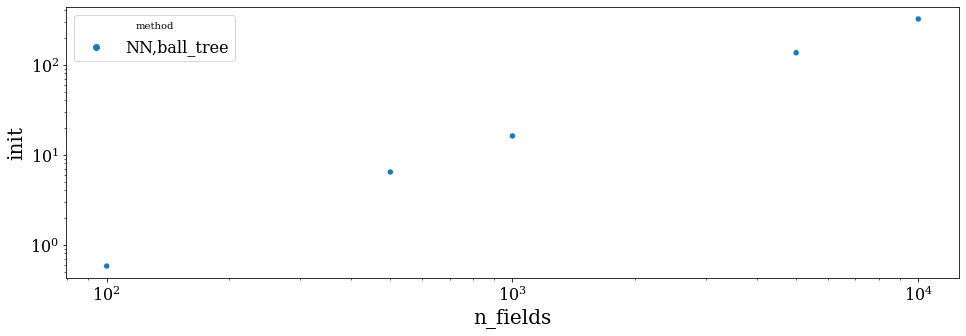

In [11]:
sns.scatterplot(data=time_elapsed, x='n_fields', y='init', hue='method', style='method')
plt.xscale('log'); plt.yscale('log');

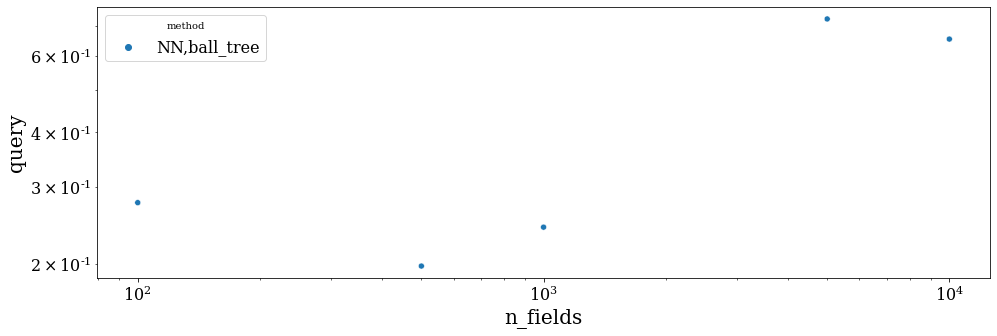

In [12]:
sns.scatterplot(data=time_elapsed, x='n_fields', y='query', hue='method', style='method')
plt.xscale('log'); plt.yscale('log');

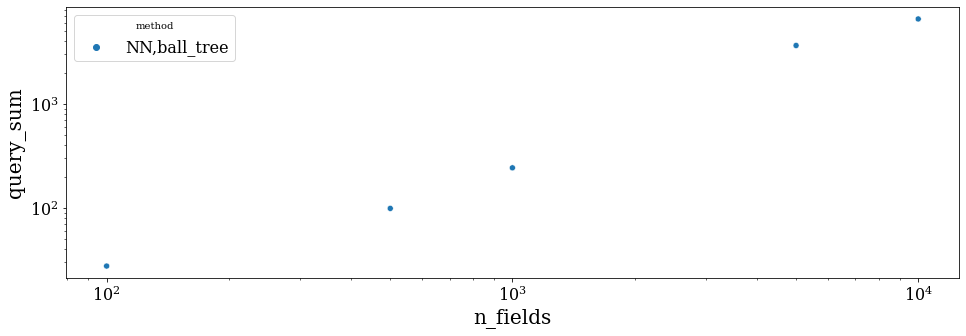

In [13]:
sns.scatterplot(data=time_elapsed, x='n_fields', y='query_sum', hue='method', style='method')
plt.xscale('log'); plt.yscale('log');

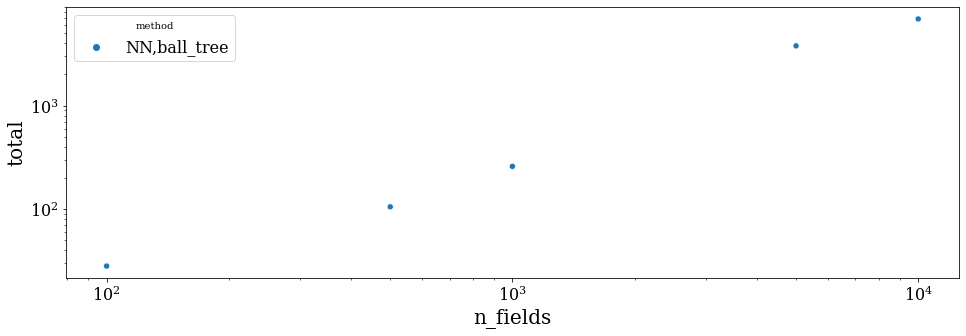

In [14]:
sns.scatterplot(data=time_elapsed, x='n_fields', y='total', hue='method', style='method')
plt.xscale('log'); plt.yscale('log');

### Approach 2: sklearn.neighbors.NearestNeighbors, `algorithm='brute'`

In [15]:
def wrapper_init():
    neigh = NearestNeighbors(metric=separation, algorithm='brute', radius=np.radians(5.))
    neigh.fit(coord)
    
    return neigh

In [16]:
def wrapper_query():
    rng = neigh.radius_neighbors([center])
    
    return rng

In [17]:
time_elapsed_init = {}
time_elapsed_query = {}
method_used = {}

In [18]:
method = 'NN,brute'

print(' #fields   t_init [s]  t_query [s]')

for n in n_fields:
    print(f'{n:8d} ', end='')
    coord, center = gen_data(n)
    
    method_used[n] = method

    time_elapsed_init[n], neigh = timeit(wrapper_init)
    print(f'{time_elapsed_init[n]:12.1f} ', end='')
    time_elapsed_query[n], rng = timeit(wrapper_query, n_iter=10)
    print(f'{time_elapsed_query[n]:12.3f}')

 #fields   t_init [s]  t_query [s]
     100          0.0        0.337
     500          0.0        1.597
    1000          0.0        3.170
    5000          0.0       15.953
   10000          0.0       30.925


In [19]:
time_elapsed_query_total = np.array(list(time_elapsed_query.keys())) * np.array(list(time_elapsed_query.values()))
time_elapsed_total = np.array(list(time_elapsed_init.values())) + time_elapsed_query_total

time_elapsed_temp = {
        'n_fields': list(time_elapsed_init.keys()),
        'method': list(method_used.values()),
        'init': list(time_elapsed_init.values()),
        'query': list(time_elapsed_query.values()),
        'query_sum': time_elapsed_query_total,
        'total': time_elapsed_total
}
del time_elapsed_query_total, time_elapsed_total
time_elapsed = pd.concat([time_elapsed, pd.DataFrame(time_elapsed_temp)])
time_elapsed

,n_fields,method,init,query,query_sum,total
0,100,"NN,ball_tree",0.578889,0.276320,27.632021,28.210911
1,500,"NN,ball_tree",6.417314,0.197804,98.901799,105.319113
2,1000,"NN,ball_tree",16.143874,0.242823,242.823346,258.967220
3,5000,"NN,ball_tree",135.567186,0.727733,3638.662803,3774.229990
4,10000,"NN,ball_tree",321.719568,0.654535,6545.349097,6867.068665
0,100,"NN,brute",0.000211,0.336826,33.682585,33.682796
1,500,"NN,brute",0.000162,1.597116,798.557830,798.557992
2,1000,"NN,brute",0.000154,3.169849,3169.848680,3169.848834
3,5000,"NN,brute",0.000181,15.953248,79766.240120,79766.240301
4,10000,"NN,brute",0.000226,30.924592,309245.916605,309245.916831


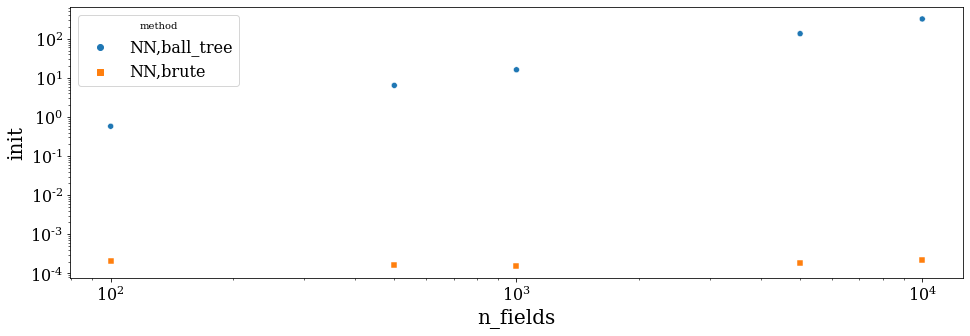

In [20]:
sns.scatterplot(data=time_elapsed, x='n_fields', y='init', hue='method', style='method', markers=('o', 's'))
plt.xscale('log'); plt.yscale('log');

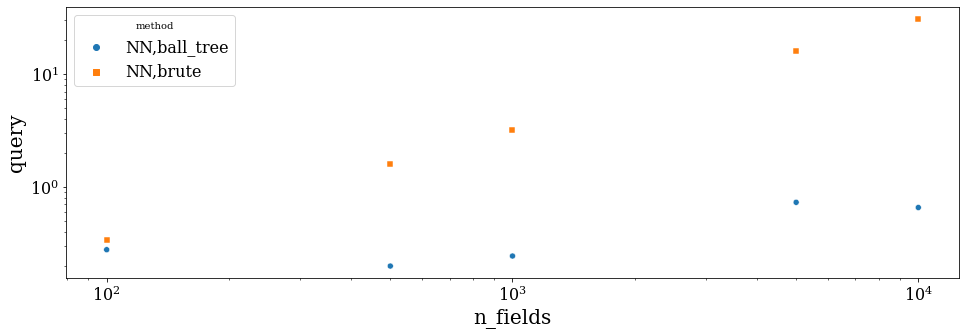

In [21]:
sns.scatterplot(data=time_elapsed, x='n_fields', y='query', hue='method', style='method', markers=('o', 's'))
plt.xscale('log'); plt.yscale('log');

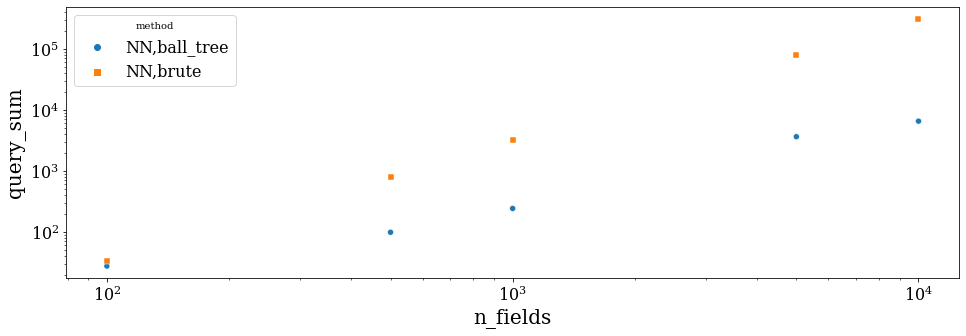

In [22]:
sns.scatterplot(data=time_elapsed, x='n_fields', y='query_sum', hue='method', style='method', markers=('o', 's'))
plt.xscale('log'); plt.yscale('log');

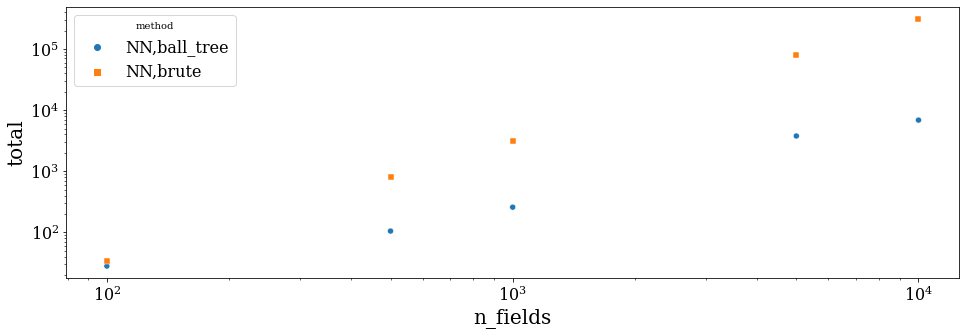

In [23]:
sns.scatterplot(data=time_elapsed, x='n_fields', y='total', hue='method', style='method', markers=('o', 's'))
plt.xscale('log'); plt.yscale('log');

### Approach 3: Python, brute-force

In [58]:
def brute_force():
    coord1 = SkyCoord(coord[:,0], coord[:,1], unit='rad')
    center1 = SkyCoord(center[0], center[1], unit='rad')
    sel = center1.separation(coord1) < 5. * u.deg
    ids = list(np.arange(coord.shape[0])[sel])
    
    return ids

In [59]:
time_elapsed_init = {}
method_used = {}

In [60]:
method = 'python'

print(' #fields   t_init [s]  t_query [s]')

for n in n_fields:
    print(f'{n:8d} ', end='')
    coord, center = gen_data(n)
    
    method_used[n] = method

    time_elapsed_init[n] = 0
    print(f'{time_elapsed_init[n]:12.1f} ', end='')
    time_elapsed_query[n], neigh = timeit(brute_force, n_iter=100)
    print(f'{time_elapsed_query[n]:12.3f}')

 #fields   t_init [s]  t_query [s]
     100          0.0        0.004
     500          0.0        0.004
    1000          0.0        0.004
    5000          0.0        0.006
   10000          0.0        0.008


In [53]:
time_elapsed_query_total = np.array(list(time_elapsed_query.keys())) * np.array(list(time_elapsed_query.values()))
time_elapsed_total = np.array(list(time_elapsed_init.values())) + time_elapsed_query_total

time_elapsed_temp = {
        'n_fields': list(time_elapsed_init.keys()),
        'method': list(method_used.values()),
        'init': list(time_elapsed_init.values()),
        'query': list(time_elapsed_query.values()),
        'query_sum': time_elapsed_query_total,
        'total': time_elapsed_total
}
del time_elapsed_query_total, time_elapsed_total
time_elapsed = pd.concat([time_elapsed, pd.DataFrame(time_elapsed_temp)])
time_elapsed

,n_fields,method,init,query,query_sum,total
0,100,"NN,ball_tree",0.578889,0.276320,27.632021,28.210911
1,500,"NN,ball_tree",6.417314,0.197804,98.901799,105.319113
2,1000,"NN,ball_tree",16.143874,0.242823,242.823346,258.967220
3,5000,"NN,ball_tree",135.567186,0.727733,3638.662803,3774.229990
4,10000,"NN,ball_tree",321.719568,0.654535,6545.349097,6867.068665
0,100,"NN,brute",0.000211,0.336826,33.682585,33.682796
1,500,"NN,brute",0.000162,1.597116,798.557830,798.557992
2,1000,"NN,brute",0.000154,3.169849,3169.848680,3169.848834
3,5000,"NN,brute",0.000181,15.953248,79766.240120,79766.240301
4,10000,"NN,brute",0.000226,30.924592,309245.916605,309245.916831


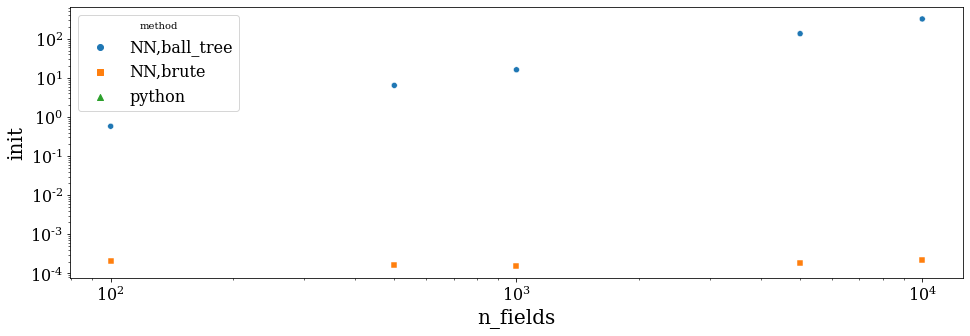

In [54]:
sns.scatterplot(data=time_elapsed, x='n_fields', y='init', hue='method', style='method', markers=('o', 's', '^'))
plt.xscale('log'); plt.yscale('log');

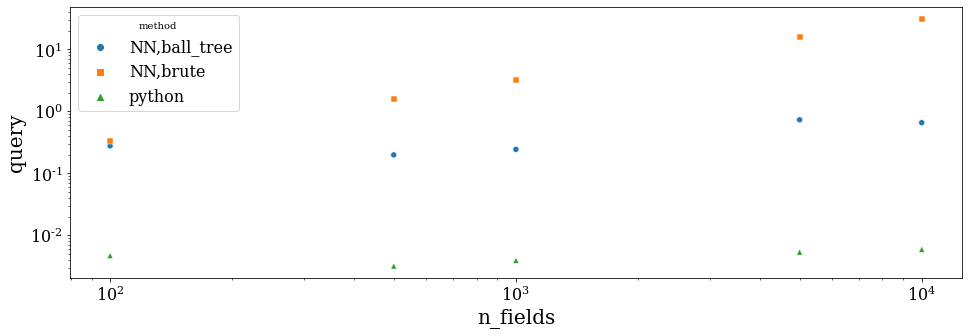

In [55]:
sns.scatterplot(data=time_elapsed, x='n_fields', y='query', hue='method', style='method', markers=('o', 's', '^'))
plt.xscale('log'); plt.yscale('log');

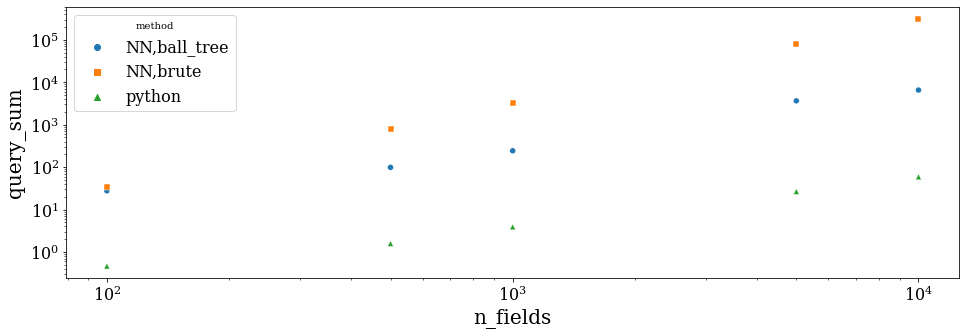

In [56]:
sns.scatterplot(data=time_elapsed, x='n_fields', y='query_sum', hue='method', style='method', markers=('o', 's', '^'))
plt.xscale('log'); plt.yscale('log');

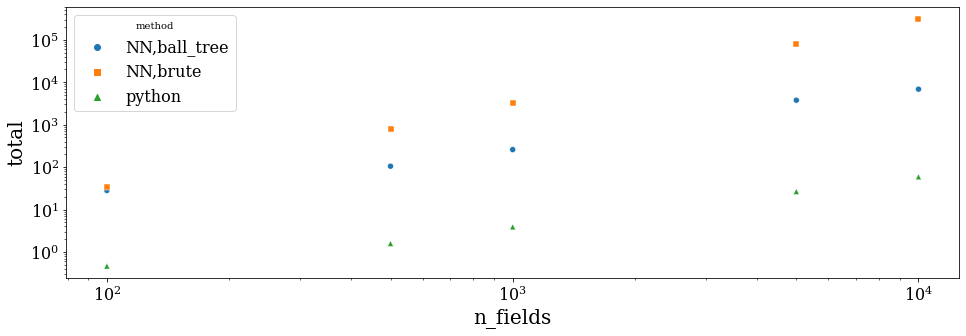

In [57]:
sns.scatterplot(data=time_elapsed, x='n_fields', y='total', hue='method', style='method', markers=('o', 's', '^'))
plt.xscale('log'); plt.yscale('log');

### Result

The simple python brute force implementation is by far the fastest. This is probably be case, because I am using a custom distance measure. scikit is specifically optimized for the usual distance measures. I suspect that it cannot vectorize the provided callable distance measure. Thus, the direct python implementation, where I use astropy's vectorization of coordinates, is faster.

<div class="alert alert-block alert-success">
<b>Decision:</b> Use a simple python implementation. No use for scikit-learn.
</div>

## On-the-fly identification vs. database query

Is it faster to identify the field neighbors on-the-fly or via database query? In the former case the identification has to be repeated each time that fields are queried for the survey planner. In the latter case the identification happens once, when fields are added to the database and associations are then queried from the database for the survey planner.

### Setup test

I the real situation we will have almost 100000 fields. I will create a test database for 100000 fields each of which has 20 neighbors. I will also create 100000 coordinates. Then I can test querying against the database vs identifying neighbors on the fly.

#### Create test database with random associations

The associations do not matter. Therefore, I simply random shuffle the IDs.

In [6]:
with sqlite3.connect('test_neigh.sqlite3') as connection:
    cursor = connection.cursor()
    
    # create table:
    query = """\
            CREATE TABLE Neighbors(
                field_id integer,
                neighbor_id integer)
            """
    cursor.execute(query)
    connection.commit()
    
    # create field IDs and 20 random associations for each field:
    field_ids = np.arange(100000)
    field_ids = np.repeat(field_ids, 20)
    neighbor_ids = np.array(field_ids)
    np.random.shuffle(neighbor_ids)
    
    # add associations to database:
    query = """\
            INSERT INTO Neighbors (
                field_id, neighbor_id)
            VALUES (?, ?);
            """
    values = [[int(f), int(n)] for f, n in zip(field_ids, neighbor_ids)]
    cursor.executemany(query, values)
    connection.commit()
    
    del field_ids, neighbor_ids, values, query

In [7]:
def query():
    field_id = np.random.randint(100000)
    
    with sqlite3.connect('test_neigh.sqlite3') as connection:
        cursor = connection.cursor()

        # create table:
        query = """\
                SELECT neighbor_id
                FROM Neighbors
                WHERE field_id = {0};
                """.format(field_id)
        results = cursor.execute(query).fetchall()
        results = [r[0] for r in results]
        
    return results

#### Create random field coordinates

In [8]:
coord, _ = gen_data(100000)

In [9]:
def brute_force():
    field_id = np.random.randint(100000)
    coords = SkyCoord(coord[:,0], coord[:,1], unit='rad')
    coords_target = coords[field_id]
    sel = coords_target.separation(coords) < 2. * u.deg
    ids = list(np.arange(coords.shape[0])[sel])
    
    return ids

### Run test

In [10]:
n_iter = 100

In [11]:
time_bf, __ = timeit(brute_force, n_iter=n_iter)

In [12]:
time_query, __ = timeit(query, n_iter=n_iter)

In [13]:
print(f'Average run time for brute force approach:    {time_bf:.2f} s')
print(f'Average run time for database query approach: {time_query:.2f} s')
print(f'Difference: {abs(time_query-time_bf):.2f} s')
print(f'Ratio:      {time_query/time_bf:.2f}')

Average run time for brute force approach:    0.03 s
Average run time for database query approach: 0.08 s
Difference: 0.05 s
Ratio:      2.87


### Result

<div class="alert alert-block alert-success">
The difference in marginal and both approaches are very fast. What this test neglects is that the brute force appoach also needs to query all coordinates first. This query will not be longer than the one done here, thus in total the brute force approach will still be very fast. There is no clear advantage in pre-identifying all neighbors and storing those associations in the database. We can simply identify them on-the-fly. The advantage of the on-the-fly approach is that we do not have to fix the radius. It can simply be a parameter stored in the database. Changing it, will only affect the later on-the-fly identifications and not any pre-identified associations, which would need to be changed.
</div>

## Conclusions

<div class="alert alert-block alert-success">
I will directly implement the pure python/astropy brute-force approach. It will run on-the-fly, when available fields have been identified.
</div>